In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from deepdiff import DeepDiff

from HANKStickyModel import HANKStickyModelClass

# Functions

In [10]:
def find_IRFs(model, model_sticky, shocks):
    # calc IRFs
    print('find IRFs (no sticky)')
    model.find_IRFs(shocks=shocks)
    if model_sticky != None:
        print('find IRFs (sticky)')
        model_sticky.find_IRFs(shocks=shocks)


def calc_jacs_IRFs(model, model_sticky=None, inattention_baseline=0.935, shocks=['eg']):
    # make sure only inattention parameter is different
    if model_sticky != None:
        assert (len(diff := DeepDiff(model.par.__dict__, model_sticky.par.__dict__)['values_changed'].keys())) == 1, diff

    print(f'Fiscal policy settings:')
    print(f'phi_G = {model.par.phi_G}')
    print(f'phi_tau = {model.par.phi_tau}')
    print(f'phi_pi = {model.par.phi_pi}')
    print(f'rho_m = {model.par.rho_m}')
    print('')

    print(f'shock settings:')
    for s in shocks:
        jump_name = 'jump_' + s
        rho_name = 'rho_' + s
        print(f'shock: {s} -> jump = {model.par.__dict__[jump_name]}, rho = {model.par.__dict__[rho_name]}')
    print('')

    # compute jacs: model without sticky information
    print('Compute Jacobians (no sticky) ')
    assert model.par.inattention == 0.0
    model._compute_jac(inputs='unknowns')
    model._compute_jac(inputs='shocks')
    # model.compute_jacs(do_print=False)
    # compute jacs: model with sticky information
    if model_sticky != None:
        print('Compute Jacobians (sticky) ')
        model_sticky.par.inattention = inattention_baseline
        model_sticky.jac_hh = deepcopy(model.jac_hh)
        model_sticky.jac_hh = model_sticky._compute_sticky_jacs_hh(model_sticky.jac_hh)
        model_sticky._compute_jac(inputs='unknowns')
        model_sticky._compute_jac(inputs='shocks')
        # model_sticky.compute_jacs(do_print=False)

    find_IRFs(model, model_sticky, shocks)


def show_only_IRFs(model, IRFs, labels, varnames,
                   abs_diff=None, lvl_value=None, facs=None, pows=None,
                   do_shocks=True, do_targets=True,
                   ncols=4, T_max=None, filename=None):
    abs_diff = [] if abs_diff is None else abs_diff
    lvl_value = [] if lvl_value is None else lvl_value
    facs = {} if facs is None else facs
    pows = {} if pows is None else pows

    par = model.par
    if T_max is None: T_max = par.T

    # full_list
    full_list = []
    if do_shocks: full_list.append(('shocks', [x for x in model.shocks]))
    full_list.append(('varnames', varnames))
    if do_targets: full_list.append(('tagets', [x for x in model.targets]))

    # default fac = 1.0
    for (typename, varnames) in full_list:
        for varname in varnames:
            if not varname in facs: facs[varname] = 1.0
            if not varname in pows: pows[varname] = 1.0

    # figures
    do_legend = any([not x is None for x in labels])
    for (typename, varnames) in full_list:

        if do_shocks or do_targets: print(f'### {typename} ###')

        num = len(varnames)
        nrows = num // ncols + 1
        if num % ncols == 0: nrows -= 1

        fig = plt.figure(figsize=(6 * ncols, 4 * nrows), dpi=100)
        for i, varname in enumerate(varnames):

            ax = fig.add_subplot(nrows, ncols, i + 1)
            title = varname
            if not np.isclose(pows[varname], 1.0): title += (' (ann.)')
            ax.set_title(title, fontsize=14)

            for label, IRF_ in zip(labels, IRFs):

                # pathvalue = model_.path.__dict__[varname][:,0]
                IRFvalue = IRF_[varname]

                if not np.isnan(getattr(model.ss, varname)):

                    ssvalue = model.ss.__dict__[varname]
                    IRFvalue = IRFvalue + ssvalue

                    if varname in lvl_value or varname in model.targets:

                        if np.isclose(ssvalue, 1.0):
                            IRFvalue = facs[varname] * IRFvalue ** pows[varname]
                        else:
                            IRFvalue = facs[varname] * ((1 + IRFvalue) ** pows[varname] - 1)

                        ax.plot(np.arange(T_max), IRFvalue[:T_max], label=label)

                        if not np.isclose(facs[varname], 1.0):
                            ax.set_ylabel(fr'{facs[varname]:.0f} x level')
                        else:
                            ax.set_ylabel('')

                    elif varname in abs_diff:

                        if np.isclose(ssvalue, 1.0):
                            ssvalue = facs[varname] * ssvalue ** pows[varname]
                            IRFvalue = facs[varname] * IRFvalue ** pows[varname]
                        else:
                            ssvalue = facs[varname] * ((1 + ssvalue) ** pows[varname] - 1)
                            IRFvalue = facs[varname] * ((1 + IRFvalue) ** pows[varname] - 1)

                        ax.plot(np.arange(T_max), IRFvalue[:T_max] - ssvalue, label=label)

                        if varname in facs:
                            ax.set_ylabel(fr'{facs[varname]:.0f} x abs. diff. to of s.s.')
                        else:
                            ax.set_ylabel('abs. diff. to of s.s.')

                    else:

                        ax.plot(np.arange(T_max), 100 * (IRFvalue[:T_max] / ssvalue - 1), label=label)

                        ax.set_ylabel('% diff. to s.s.')

                else:

                    ax.plot(np.arange(T_max), IRFvalue[:T_max], label=label)

            if (len(labels) > 1) and i == 0: ax.legend(frameon=True)

        fig.tight_layout(pad=3.0)
        plt.show()
        print('')

        # save
        if not filename is None: fig.savefig(f'{filename}_{typename}.pdf')

# Baseline model

In [7]:
# model = HANKStickyModelClass(name='test')
model = HANKStickyModelClass(name='baseline_2602', par = {'beta_mean': 0.9988,
                                                         'sigma_e': 0.36})

In [8]:
# model.load()
model.find_ss(do_print=True)

find beta for market clearing
 [beta, sigma_e] = [  0.998800000000,   0.360000000000] -> [ss.clearing_Y =   0.000231564242, ss.clearing_MPC =  -0.003893598190] [14.7 secs]
 [beta, sigma_e] = [  0.998800000000,   0.360000000000] -> [ss.clearing_Y =   0.000231564242, ss.clearing_MPC =  -0.003893598190] [8.9 secs]
 [beta, sigma_e] = [  0.998800000000,   0.360000000000] -> [ss.clearing_Y =   0.000231564242, ss.clearing_MPC =  -0.003893598190] [9.4 secs]
 [beta, sigma_e] = [  0.998800014883,   0.360000000000] -> [ss.clearing_Y =   0.000231505769, ss.clearing_MPC =  -0.003892680925] [8.6 secs]
 [beta, sigma_e] = [  0.998800000000,   0.360000005364] -> [ss.clearing_Y =   0.000231563740, ss.clearing_MPC =  -0.003893593267] [8.6 secs]
 [beta, sigma_e] = [  0.998870226555,   0.359526595375] -> [ss.clearing_Y =  -0.000003386733, ss.clearing_MPC =   0.000022871562] [8.6 secs]
 [beta, sigma_e] = [  0.998870675861,   0.359471319250] -> [ss.clearing_Y =   0.000000061321, ss.clearing_MPC =   0.0000011

# Baseline IRFs

In [11]:
model.par.phi_G = 0.5
model.par.phi_pi = 1.25
model.par.rho_m = 0.89
model.par.phi_tau = 0.1
# model.blocks = [
#             'blocks.production_firm',
#             'blocks.capital_firm',
#             'blocks.price_setters_no_indexation',
#             'blocks.mutual_fund',
#             'blocks.government',
#             'hh',
#             'blocks.union_no_indexation',
#             'blocks.taylor',
#             'blocks.fisher',
#             'blocks.real_wage',
#             'blocks.market_clearing']

model.par.rho_eg = 0.85
model.par.jump_eg = 0.01
model.par.jump_eg_transfer = 0.0
model.par.jump_em = 0.0
delta_G = model.par.jump_eg * model.par.rho_eg ** np.arange(model.par.T)
print(f'Shock with parameters jump = {model.par.jump_eg}, rho = {model.par.rho_eg} leads to a total spending increase of {delta_G.sum()*100:.2f}%')

Shock with parameters jump = 0.01, rho = 0.85 leads to a total spending increase of 6.67%


In [12]:
model.compute_jacs(do_print=True)
# model._compute_jac(inputs='unknowns',do_print=True)
# model._compute_jac(inputs='shocks',do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for eg_transfer     in 5.6 secs
curly_Y and curly_D calculated for ra              in 6.2 secs
curly_Y and curly_D calculated for rl              in 6.3 secs
curly_Y and curly_D calculated for tau             in 5.9 secs
curly_Y and curly_D calculated for wN              in 5.7 secs
curly_E calculated in 3.3 secs
builiding blocks combined in 2.8 secs
household Jacobian computed in 35.8 secs

full Jacobians:
full Jacobian to unknowns computed in 8.4 secs [in evaluate_blocks(): 5.1 secs]
full Jacobian to shocks computed in 3.2 secs [in evaluate_blocks(): 0.4 secs]


In [13]:
model.find_IRFs(shocks=['eg'])

### shocks ###


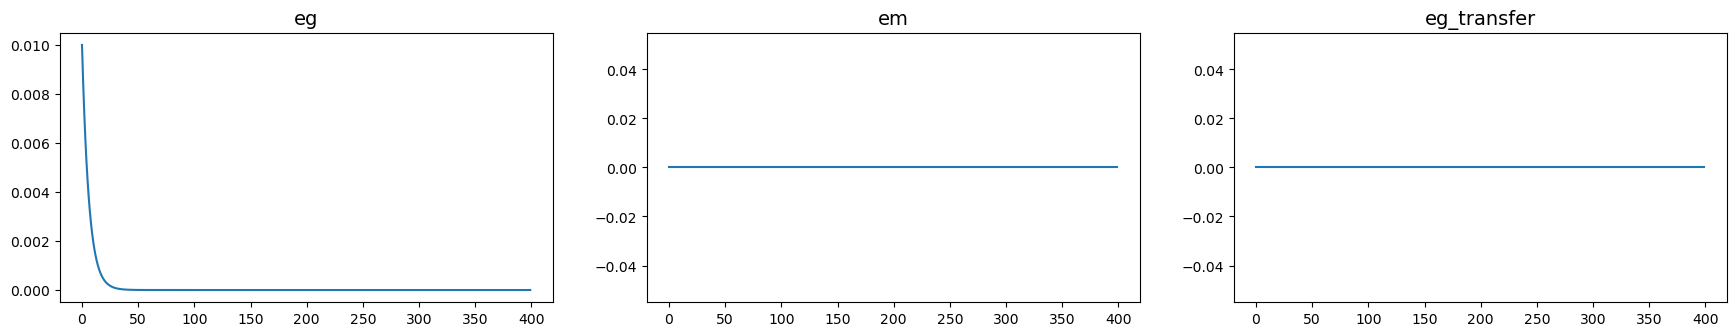


### varnames ###


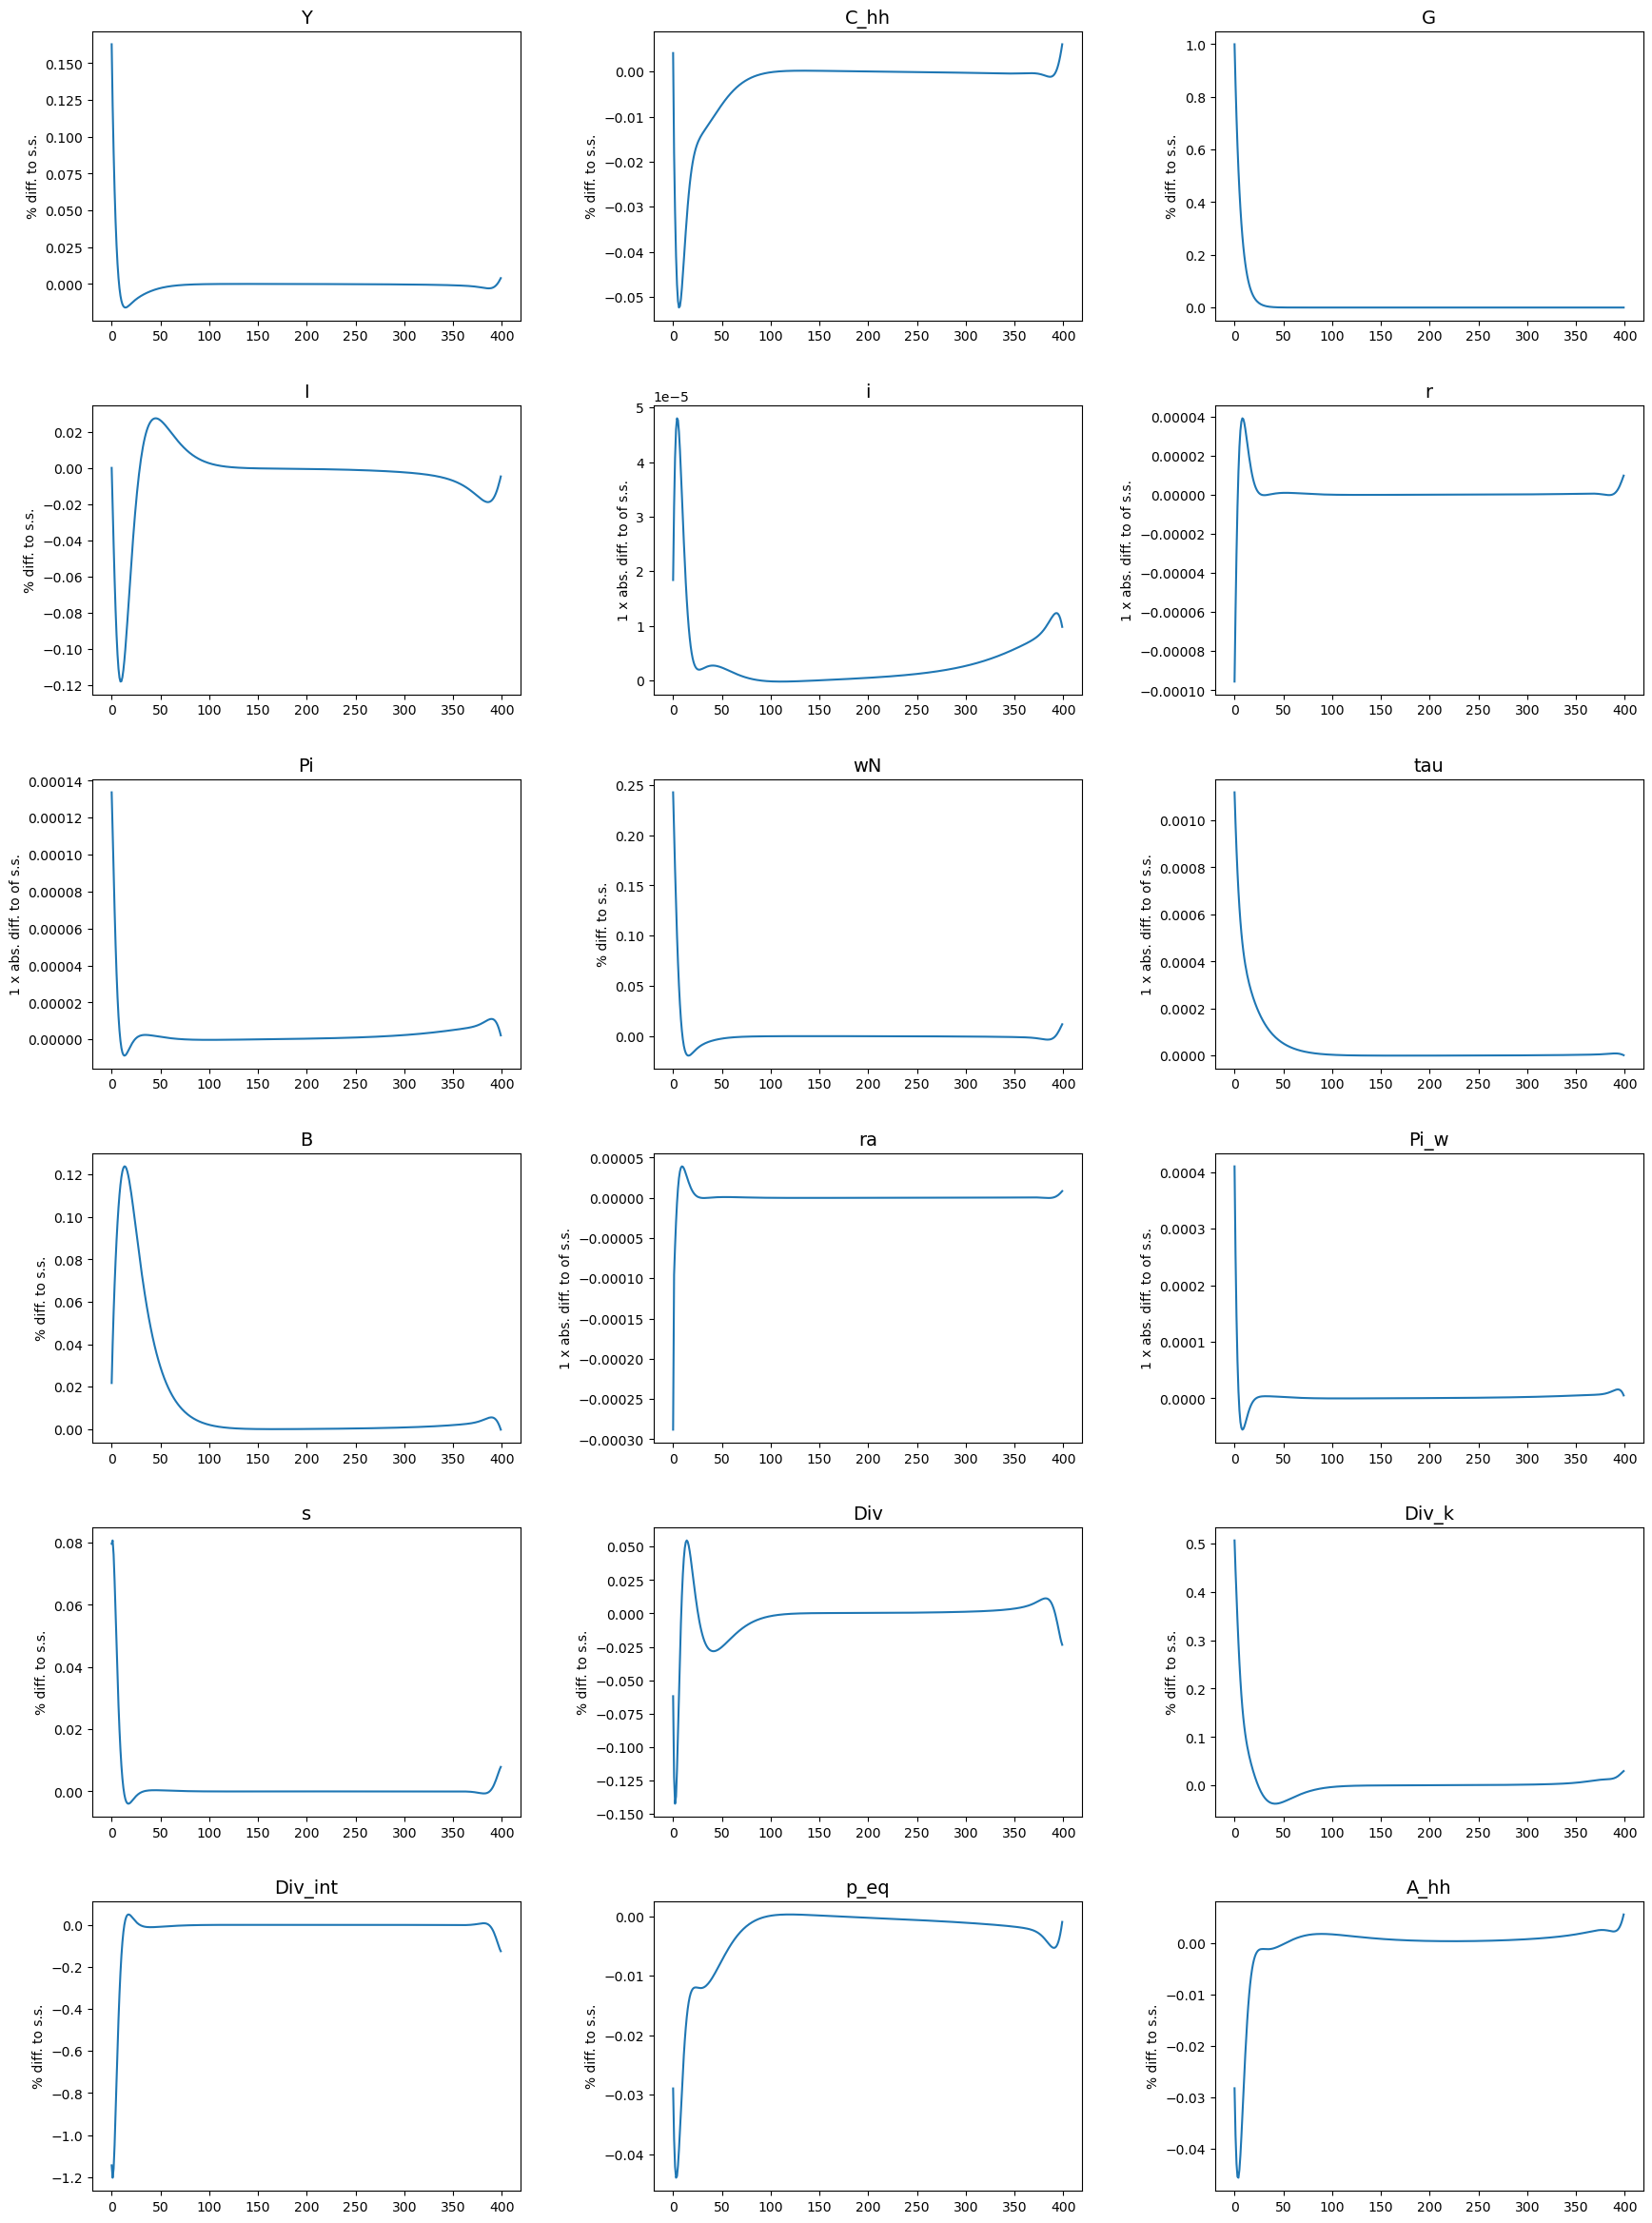

In [14]:
models = [model]
labels = ['baseline no sticky',]
paths = ['Y', 'C_hh', 'G', 'I', 'i', 'r', 'Pi', 'wN', 'tau', 'B','ra', 'Pi_w','s', 'Div', 'Div_k', 'Div_int', 'p_eq', 'A_hh']
paths_short = ['Y', 'C_hh', 'Pi']
lvl_value = ['eg', 'ez', 'em', 'eg_transfer', 'd_tau', 'd_B', 'd_G','eB','etau','eG']
abs_diff = ['tau',  'r', 'Pi', 'i', 'rk','Pi_w','ra']
# facs = {'r':100}
model.show_IRFs(paths,lvl_value=lvl_value,abs_diff=abs_diff,ncols=3,T_max=model.par.T,do_linear=True,do_shocks=True, do_non_linear=False, do_targets=False)
# model.show_IRFs(paths,lvl_value=lvl_value,abs_diff=abs_diff,ncols=3,T_max=25,do_linear=True,do_shocks=True, do_non_linear=True)

# Sensitivity phi_K

In [19]:
phi_Ks = [1.0, 2.5, 5.0, 9.0]
IRFs_phi_K = {}
for phi_K in phi_Ks:
    model.par.phi_K = phi_K
    calc_jacs_IRFs(model, inattention_baseline = 0.935, shocks=['eg'])
    IRFs_phi_K[phi_K] = deepcopy(model.IRF)

Fiscal policy settings:
phi_G = 0.5
phi_tau = 0.1
phi_pi = 1.25
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.85

Compute Jacobians (no sticky) 
find IRFs (no sticky)
Fiscal policy settings:
phi_G = 0.5
phi_tau = 0.1
phi_pi = 1.25
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.85

Compute Jacobians (no sticky) 
find IRFs (no sticky)
Fiscal policy settings:
phi_G = 0.5
phi_tau = 0.1
phi_pi = 1.25
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.85

Compute Jacobians (no sticky) 
find IRFs (no sticky)
Fiscal policy settings:
phi_G = 0.5
phi_tau = 0.1
phi_pi = 1.25
rho_m = 0.89

shock settings:
shock: eg -> jump = 0.01, rho = 0.85

Compute Jacobians (no sticky) 
find IRFs (no sticky)


### shocks ###


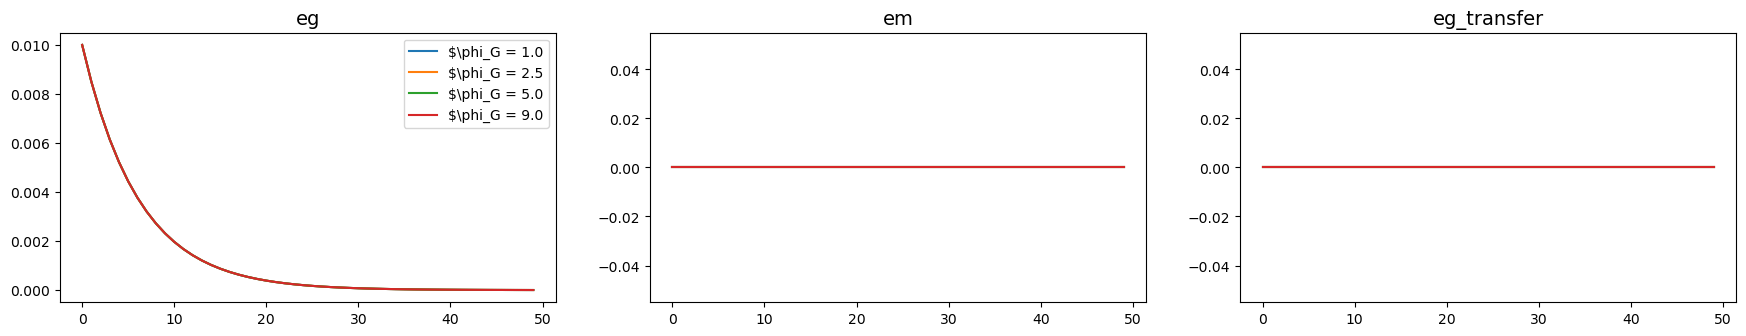


### varnames ###


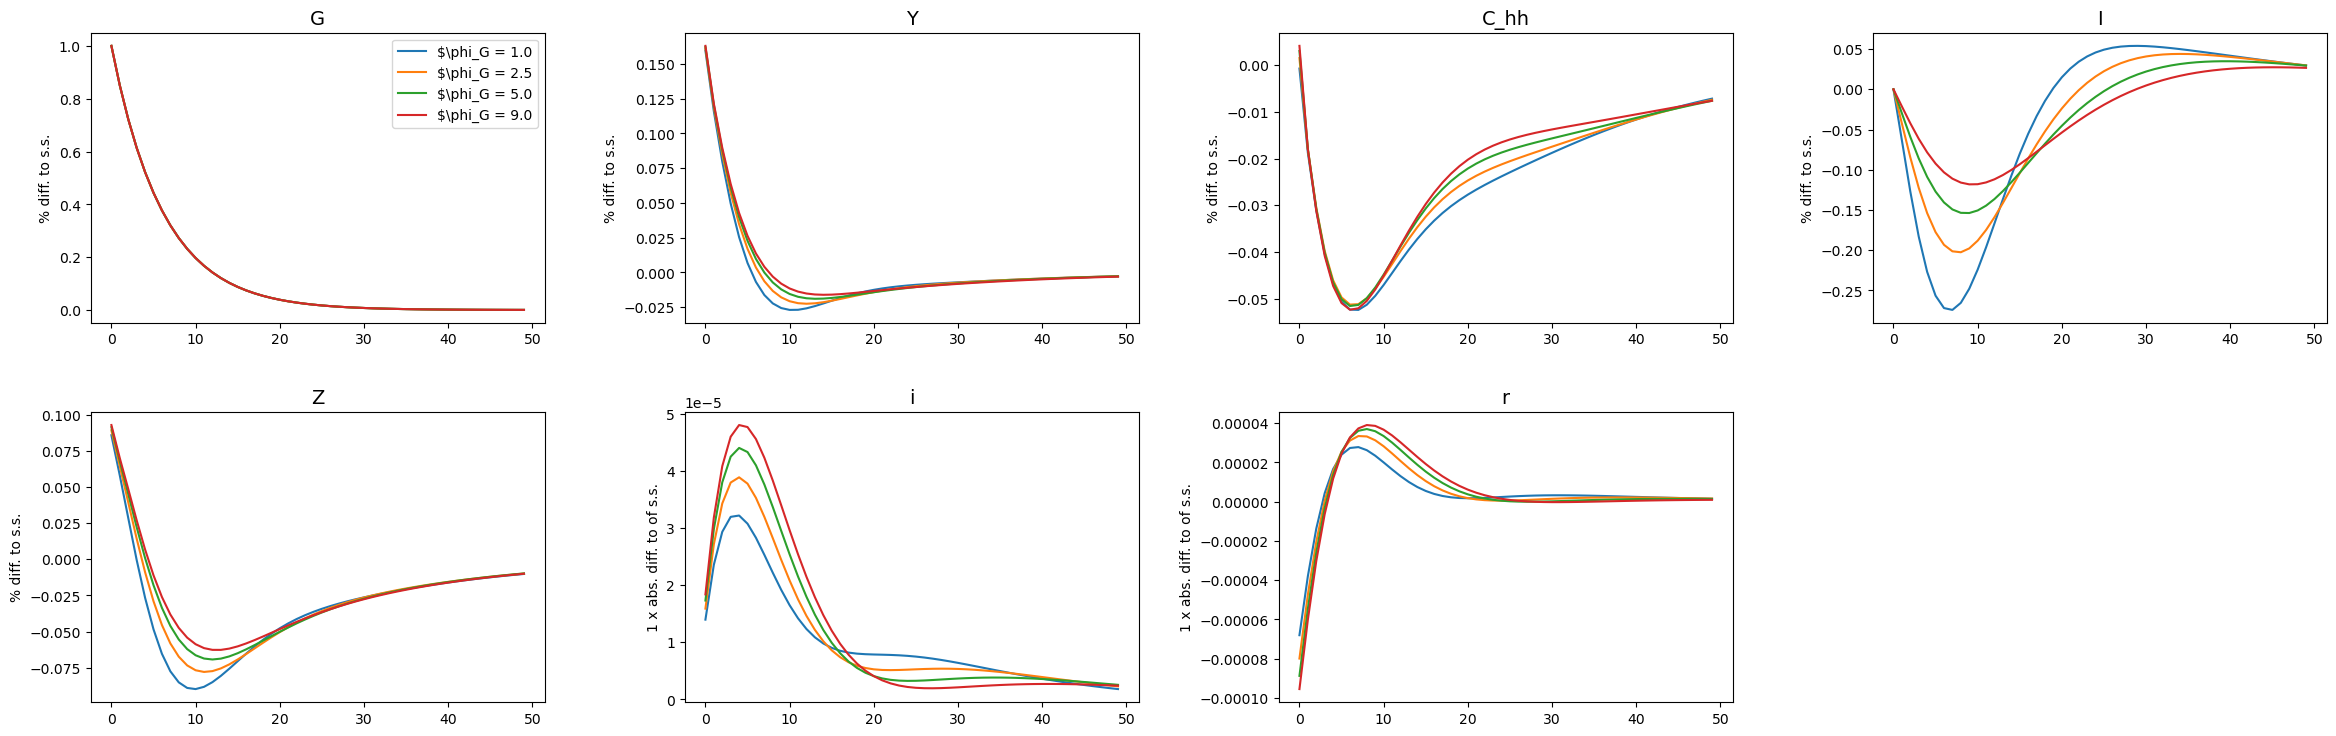


### tagets ###


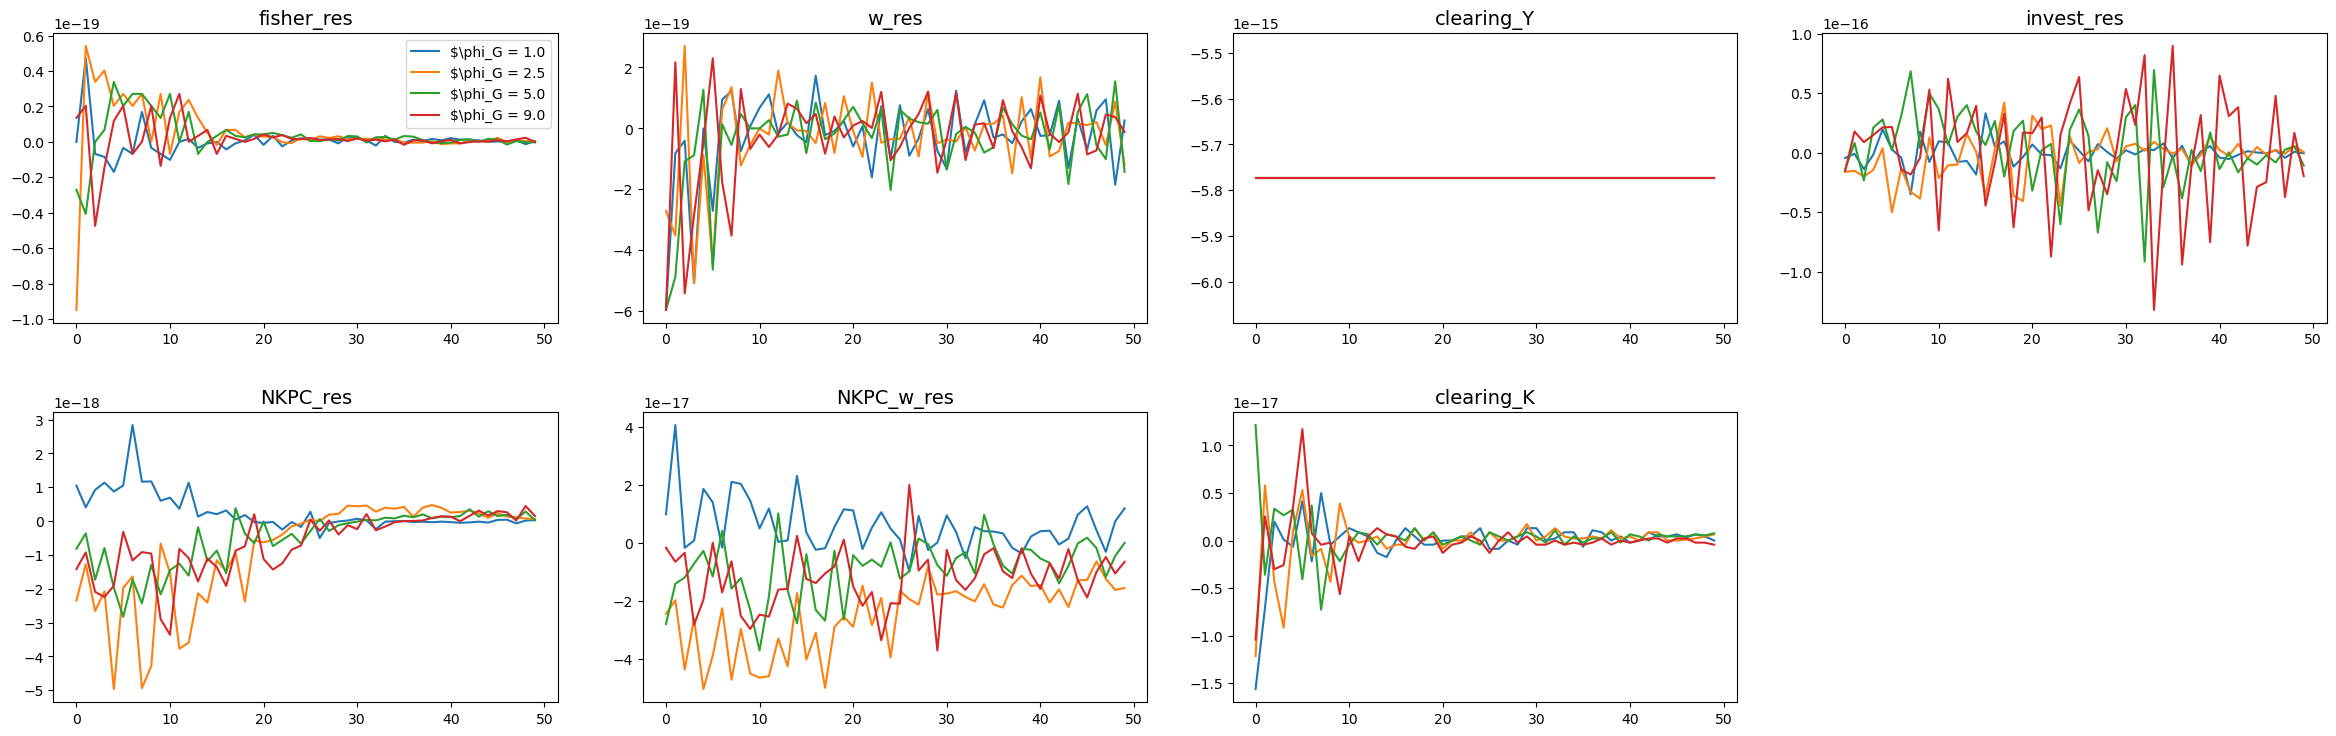

In [20]:
labels = [f'$\phi_G = {phi_K}' for phi_K in phi_Ks]
# labels_sticky = [f'$\phi_G = {model_sticky.par.phi_G}, \\theta = {model_sticky.par.inattention}$, phi_pi = {phi_pi}' for phi_pi in phi_pis]
paths_short = ['G', 'Y', 'C_hh', 'I', 'Z', 'i','r']
paths2 = ['G', 'Y', 'C_hh', 'i', 'r', 'Pi', 'Pi_w', 'w', 'N', 'K', 's', 'rk', 'B', 'tau', 'Z']
lvl_value = ['eg', 'eg_transfer', 'em', 'Pi','Pi_w']
abs_diff = ['tau',  'r', 'Pi', 'i', 'rk', 'ra', 'Pi_w']
show_only_IRFs(model, list(IRFs_phi_K.values()), labels, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, T_max=50)
# show_only_IRFs(model_sticky, list(IRFs_sticky_phi_pi.values()), labels_sticky, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, T_max=50)